In [1]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge, ElasticNetCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.model_selection import RepeatedKFold, KFold, RandomizedSearchCV, train_test_split
#from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as MSE
#from mpl_toolkits.mplot3d import Axes3D # to plot in 3D
from scipy import stats # for z-score
from scipy.cluster import hierarchy as hc
#from pynverse import inversefunc
from scipy.stats import spearmanr, wilcoxon
import time

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_context(context="paper", font_scale=1.4, rc=None) #"talk" "paper"

## Load the data

One of the phantom datasets

In [2]:
# read the data
df = pd.read_excel("radiomics_phantoms_5x.xlsx")

# drop 1024-by-1024 pixel images
df = df.drop(list(df.loc[df["Rows&Columns"] == 1024].index))
# rename the central ROI to '0'
df.ROI_name[df.ROI_name == 'center'] = '0' 

# Radiomics correction tools 
The radiomics correction toolbox (rctools) contains the following functions:
* map_dict -- to compute parallel DataFrame operations;
* correction_fit -- to build a correction model;


In [3]:
def map_dict(func, namespace):
    output_dict = dict(zip(
        list(namespace),
        list(map(
            func,
            namespace
        ))
    ))
    return output_dict


def correction_fit(X, Y):
    model = LinearRegression()
    model.fit(X, Y)
    return model


# if select features with CS
select_with_CS = True

## Batch radiomics correction

1. Pre-select data -> creates df_rad_bef;
2. Calculate TRV matrix -> creates df_TRV;
3. Calculate correctability matrices -> creates df_CS, df_Spearman;
    - 3.1. Calculate correctability score CS;
    - 3.2. Calculate Spearman ranks;
    - 3.3. Select unstable radiomic features;
4. Train models -> creates model_dict;
    - This operation uses TRV-shifted data;
5. Correct radiomic features -> creates df_rad_aft;
6. Evaluate correction -> creates df_ES;
7. Visualize.

*TRV == y_c - target radiomic value.*

### 1. Pre-select data
This operation creates *df_rad_bef* DataFrame with pre-corrected radiomic feature values

In [4]:
# to select meta data
meta_features = ['PatientID', 'Exposure', 'SliceThickness', 'Rows&Columns', 'ROI_name', 'ScanSeriesID']

# to select radiomic features
radiomic_features = list(df.columns[19:])
"""radiomic_features = [
                     #"original_firstorder_10Percentile",
                     "original_firstorder_MeanAbsoluteDeviation",
                     #"original_firstorder_RobustMeanAbsoluteDeviation",
                     "original_gldm_GrayLevelNonUniformity",
                     *df.columns[25:40],
                     #"original_glrlm_GrayLevelNonUniformity",
                     #"original_firstorder_Energy",
                     #"original_firstorder_Mean"
]"""
radiomic_features = list(set(radiomic_features))

# locate in the initial dataframe
loc_data = (df["Rows&Columns"] == 512 * 1)# * (df["ROI_name"] != "9" * 1)
df_rad_pre = df[meta_features + radiomic_features].loc[loc_data]
df_rad_pre = pd.DataFrame(
    data=df_rad_pre.values,
    columns=meta_features + radiomic_features,
    index=range(df_rad_pre.shape[0])
)

### 2. Calculate TRV matrix
This operation creates *df_TRV* DataFrame of calculated target radiomic values (TRVs)

In [5]:
time_start = time.time()
# set the TRV condition
condition={"Exposure": 200}

# calculate TRV
df_TRV = pd.DataFrame(map_dict(
    lambda feature: map_dict(
        lambda ROI: df_rad_pre[feature].loc[df_rad_pre.index[np.where(df_rad_pre[list(condition.keys())].isin(list(condition.values())))[0]]].loc[df_rad_pre.ROI_name == ROI].values.mean(),
        np.unique(df_rad_pre.ROI_name)
    ),
    radiomic_features
)).loc[list(map(str, range(17)))]
print(f"Finished in {time.time() - time_start:.2f} seconds")

Finished in 2.28 seconds


### 3. Calculate correctability matrices
    - 3.1. Calculate correctability score CS;
    - 3.2. Calculate Spearman ranks;
    - 3.3. Select unstable radiomic features.
This operation creates *df_CS* and *df_Spearman* DataFrames of correctability creteria

In [6]:
time_start = time.time()

df_Spearman = pd.DataFrame(map_dict(
    lambda feature: map_dict(
        lambda plug: spearmanr(df_rad_pre.Exposure.loc[(df_rad_pre.ROI_name == plug)] ** -.5, df_rad_pre[feature].loc[(df_rad_pre.ROI_name == plug)])[0],
        np.unique(df_rad_pre.ROI_name)
    ),
    radiomic_features
)).loc[list(map(str, range(17)))]

# support matrix: TRV-shifted data
df_shifted = df_rad_pre[radiomic_features] - df_TRV[radiomic_features].loc[df_rad_pre.ROI_name].values
df_shifted["Exposure"] = df_rad_pre.Exposure

# calculate CS
df_CS = pd.DataFrame(
    np.std(list(map(
        lambda param: np.mean(df_shifted[radiomic_features].loc[(df_shifted.Exposure == param)]),
        np.unique(df_shifted.Exposure)
    )), axis=0) / np.mean(list(map(
        lambda param: np.std(df_shifted[radiomic_features].loc[(df_shifted.Exposure == param)]),
        np.unique(df_shifted.Exposure)
    )), axis=0),
    index=radiomic_features, columns=["CS"]
).T

# select unstable features if True
if select_with_CS:
    radiomic_features_sel = list(df_CS[df_CS.columns[np.where(df_CS > 2)[1]]].sort_values(by="CS", axis=1).columns)
else:
    radiomic_features_sel = radiomic_features

print(f"Finished in {time.time() - time_start:.2f} seconds")

Finished in 2.18 seconds


### 4. Train models
    - This operation uses TRV-shifted data
This operation creates *model_dict* dictionary for models for each radiomic feature in *radiomic_features_sel* list. You may change the predictors by uncommenting transformation functions.

In [7]:
func_dict = {
    "linear": lambda x: x,
    "square": lambda x: x ** 2,
    #"power-1": lambda x: (x + 1e-100) ** -1,
    #"sqrt": np.sqrt,
    #"log10": lambda x: np.log10(x + 1e-100),
    #"exp": np.exp
}

# predictors - scanner parameters
X = df_rad_pre.Exposure.values.reshape(-1, 1) ** - 0.5
# create non-linear predictors
X = np.array(list(map(lambda func: func(X.reshape(-1,)), func_dict.values()))).T

# create the dictionary of models
model_dict = map_dict(lambda feature: correction_fit(X, Y=df_shifted[feature].values), radiomic_features_sel)

### 5. Correct radiomic features
This operation creates *df_rad_aft* DataFrame with corrected radiomic feature values

In [8]:
df_rad_aft = df_rad_pre[meta_features]

df_rad_aft[radiomic_features_sel] = pd.DataFrame(map_dict(
    lambda feature: df_rad_pre[feature].values.reshape(-1,) - model_dict[feature].predict(X).reshape(-1,),
    radiomic_features_sel
))

### 6. Evaluate correction
This operation creates *df_ES* DataFrame of evaluation scores

In [9]:
df_std_orig = pd.DataFrame(map_dict(
    lambda feature: map_dict(
        lambda ROI: np.std(df_rad_pre[feature].loc[(df_rad_pre.ROI_name == ROI)]),
        np.unique(df_rad_pre.ROI_name)
    ),
    radiomic_features_sel
)).T
df_std_orig = df_std_orig[list(map(str, range(17)))]

df_std_corr = pd.DataFrame(map_dict(
    lambda feature: map_dict(
        lambda ROI: np.std(df_rad_aft[feature].loc[(df_rad_aft.ROI_name == ROI)]),
        np.unique(df_rad_aft.ROI_name)
    ),
    radiomic_features_sel
)).T
df_std_corr = df_std_corr[list(map(str, range(17)))]

df_ES = (df_std_orig / df_std_corr).T

### 7. Visualization

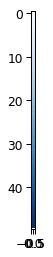

In [10]:
# font settings
axis_font = {"fontsize":20, "fontweight":None}

# for colorbar
img = plt.imshow(np.linspace(np.min(df_ES.values), np.max(df_ES.values)).reshape(-1,1), cmap="Blues")

# plug indices
dict_plugs = {
    "0": "Phantom – Solid water",
    "1": "SB3 Cortical Bone",
    "2": "BRN-SR2 Brain",
    "3": "AP6 Adipose",
    "4": "CB2 - 50% CaCO3",
    "5": "CT Solid Water1",
    "6": "CB2 - 30% CaCO3",
    "7": "Water",
    "8": "BR-12 Breast", 
    "9": "LN-300 Lung",
    "10": "CT Solid Water2",
    "11": "IB Inner Bone",
    "12": "CT Solid Water",
    "13": "LV1 Liver",
    "14": "B200 Bone Mineral",
    "15": "LN-450 Lung",
    "16": "CT Solid Water3"
}

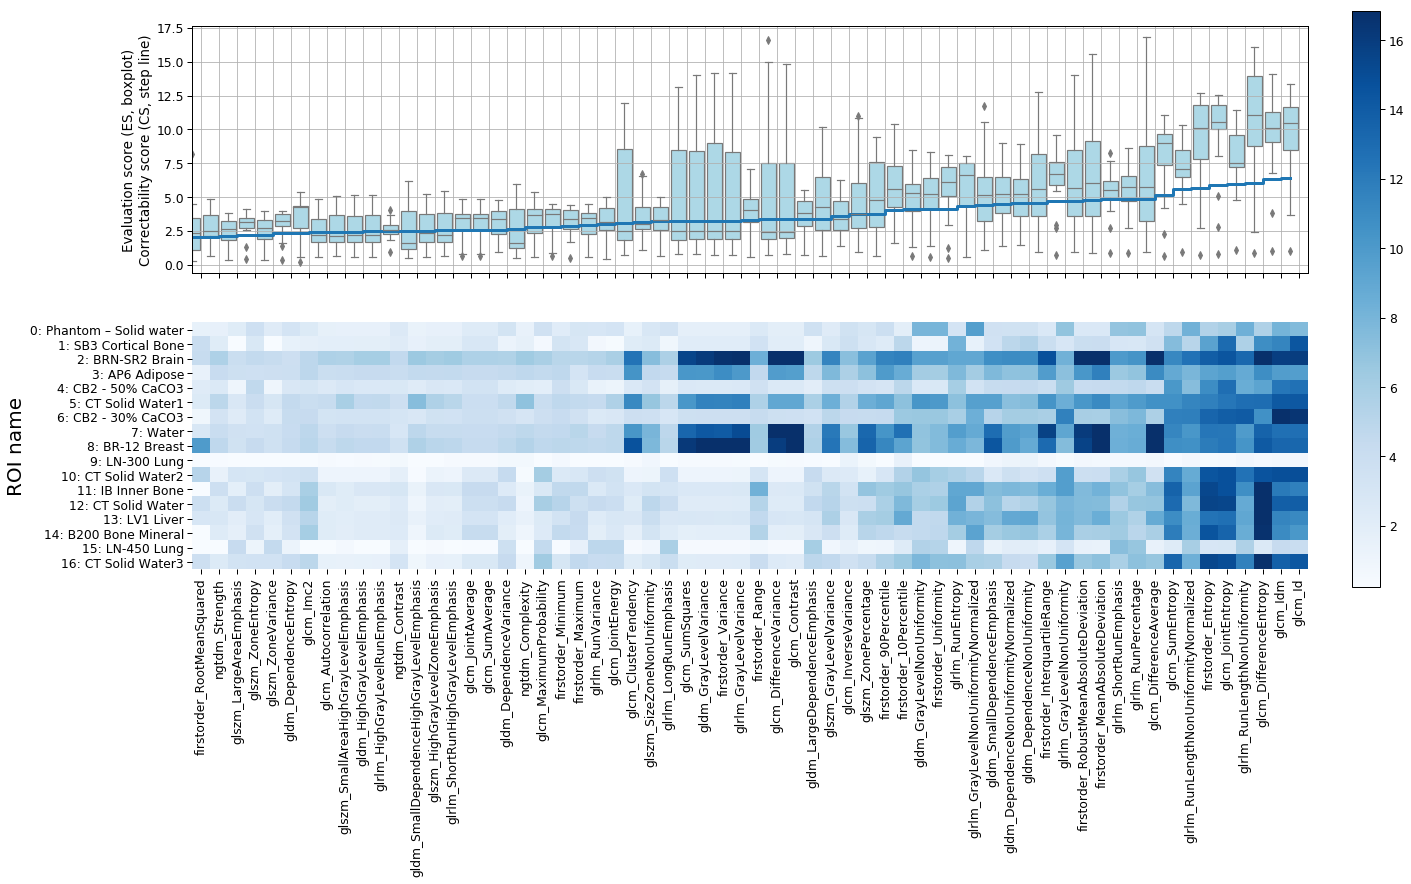

In [11]:
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 2]) 
# the fisrt subplot
ax0 = plt.subplot(gs[0])
# log scale for axis Y of the first subplot
line0 = sns.boxplot(data=df_ES[radiomic_features_sel], color="LightBlue", saturation=1)

# correctability score
plt.step(np.arange(len(radiomic_features_sel)), df_CS[radiomic_features_sel].T, where='mid', linewidth=3)
#plt.axhline(y=1, color="red")
ax0.grid()


#the second subplot
# shared axis X
ax1 = plt.subplot(gs[1], sharex = ax0)

line1 = sns.heatmap(df_ES[radiomic_features_sel], cbar=False, cmap="Blues", robust=True)
plt.xticks(
    np.arange(len(radiomic_features_sel)) + 0.5,
    list(map(lambda string: string[9:], radiomic_features_sel)),
    rotation=90)
plt.setp(ax0.get_xticklabels(), visible=False)
# remove last tick label for the second subplot
yticks = ax1.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
privet = plt.xticks()
plt.yticks(list(ax1.get_yticks())+ [16.5], list(map(lambda x: x + ": " + dict_plugs[x], dict_plugs.keys())) + ["16: CT Solid Water3"])
ax0.set_ylabel("Evaluation score (ES, boxplot)\nCorrectability score (CS, step line)")
ax1.set_ylabel("ROI name", fontsize=20)

# colormap
cb_ax = fig.add_axes([0.93, 0.1, 0.02, 0.8])
cbar = fig.colorbar(img, cax=cb_ax)


## SANDBOX